In [128]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
plt.style.use('default')
pd.set_option('display.max_columns', None)

In [129]:
with open("../Data/simu8_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
df_study = df_study.loc[df_study.session < 100]
df_test = df_test.loc[df_test.session < 100]

In [130]:
df_study.head(16)

,study_itemno1,study_itemno2,study_item1,study_item2,serial_pos,list,session
0,12,24,Face12,Joe,0,0,0
1,2,29,Face2,Mark,1,0,0
2,6,27,Face6,Dan,2,0,0
3,13,18,Face13,John,3,0,0
4,11,31,Face11,George,4,0,0
5,8,19,Face8,Rob,5,0,0
6,1,30,Face1,Mike,6,0,0
7,14,22,Face14,Rich,7,0,0
8,11,31,Face11,George,0,1,0
9,14,22,Face14,Rich,1,1,0


In [131]:
df_test

,test_itemno,test_item,correct_ans,study_pos,list,session
0,1,Face1,30,6,0,0
1,2,Face2,29,1,0,0
2,6,Face6,27,2,0,0
3,14,Face14,22,7,0,0
4,13,Face13,18,3,0,0
...,...,...,...,...,...,...
7995,2,Face2,32,6,9,99
7996,1,Face1,25,5,9,99
7997,7,Face7,30,3,9,99
7998,9,Face9,17,1,9,99


### Distance

In [132]:
face_distance = np.load('../Data/simu8_distance.npy')

In [133]:
def get_distance(df_tmp):
    faces = np.unique(df_tmp.test_itemno)
    face_dist = {}
    for face in faces:
        this_dist = []
        for other_face in faces:
            if face != other_face:
                this_dist.append(face_distance[face-1,other_face-1])
        this_dist = np.array(this_dist)
        face_dist[face] = this_dist
    y = df_tmp.apply(lambda x: face_dist[x['test_itemno']],axis=1)
    return y
df_test['distance'] = df_test.groupby("session").apply(get_distance).to_frame(name='distance').reset_index()['distance']
df_test

,test_itemno,test_item,correct_ans,study_pos,list,session,distance
0,1,Face1,30,6,0,0,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095..."
1,2,Face2,29,1,0,0,"[1.0709, 2.0108, 2.4045, 3.7211, 3.5024, 2.597..."
2,6,Face6,27,2,0,0,"[2.202, 2.0108, 3.194, 2.8217, 3.9032, 1.6004,..."
3,14,Face14,22,7,0,0,"[2.9509, 2.9187, 2.4855, 1.8175, 2.3944, 3.368..."
4,13,Face13,18,3,0,0,"[2.8095, 2.5971, 1.6004, 2.5139, 2.5733, 3.678..."
...,...,...,...,...,...,...,...
7995,2,Face2,32,6,9,99,"[1.0709, 2.9597, 1.601, 3.2682, 3.2787, 3.8765..."
7996,1,Face1,25,5,9,99,"[1.0709, 2.1647, 2.0873, 2.8935, 3.5825, 3.939..."
7997,7,Face7,30,3,9,99,"[2.8935, 3.2682, 2.2956, 2.5197, 3.3644, 2.473..."
7998,9,Face9,17,1,9,99,"[3.5825, 3.2787, 3.3268, 3.2177, 3.3644, 1.838..."


In [134]:
distance_thresh = 3
df_test['neighbour'] = df_test.apply(lambda x: sum(x['distance'] < distance_thresh), axis=1)
df_test['neighbour_group'] = df_test.apply(lambda x: 6 if x['neighbour'] == 7 else x['neighbour'], axis=1)
df_test

,test_itemno,test_item,correct_ans,study_pos,list,session,distance,neighbour,neighbour_group
0,1,Face1,30,6,0,0,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095...",5,5
1,2,Face2,29,1,0,0,"[1.0709, 2.0108, 2.4045, 3.7211, 3.5024, 2.597...",5,5
2,6,Face6,27,2,0,0,"[2.202, 2.0108, 3.194, 2.8217, 3.9032, 1.6004,...",5,5
3,14,Face14,22,7,0,0,"[2.9509, 2.9187, 2.4855, 1.8175, 2.3944, 3.368...",6,6
4,13,Face13,18,3,0,0,"[2.8095, 2.5971, 1.6004, 2.5139, 2.5733, 3.678...",6,6
...,...,...,...,...,...,...,...,...,...
7995,2,Face2,32,6,9,99,"[1.0709, 2.9597, 1.601, 3.2682, 3.2787, 3.8765...",3,3
7996,1,Face1,25,5,9,99,"[1.0709, 2.1647, 2.0873, 2.8935, 3.5825, 3.939...",4,4
7997,7,Face7,30,3,9,99,"[2.8935, 3.2682, 2.2956, 2.5197, 3.3644, 2.473...",5,5
7998,9,Face9,17,1,9,99,"[3.5825, 3.2787, 3.3268, 3.2177, 3.3644, 1.838...",2,2


In [135]:
df_test.groupby('neighbour')['neighbour'].count()

neighbour
0      10
1     270
2     900
3    1980
4    2340
5    1870
6     550
7      80
Name: neighbour, dtype: int64

### Run CMR-IA

In [136]:
s_mat = np.load('../Data/simu8_smat.npy')

<Axes: >

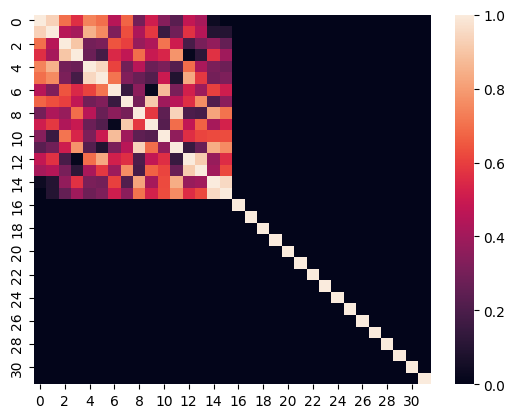

In [149]:
sns.heatmap(s_mat)

In [137]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.5,
    beta_rec = 0.6,
    beta_rec_new = 0,
    beta_rec_post = 0.01,
    gamma_fc = 0.5,  # cf - fc Higher, -1 Higher
    gamma_cf = 0.5,
    s_fc = 0,
    s_cf = 0,
    c_thresh = 0.01,
    c_thresh_ass = 0.01,
    a = 2800,
    b = 2.14,
    m = 0,
    n = 1,
    kappa = 0.08,
    lamb = 0.04,
    eta = 0.02,
    omega = 8,
    phi_s = 1,
    phi_d = 0.6,
    nitems_in_accumulator = 20,
    d_ass = 1
)
params

{'beta_enc': 0.5,
 'beta_rec': 0.6,
 'beta_rec_new': 0,
 'beta_rec_post': 0.01,
 'beta_distract': None,
 'phi_s': 1,
 'phi_d': 0.6,
 's_cf': 0,
 's_fc': 0,
 'kappa': 0.08,
 'eta': 0.02,
 'omega': 8,
 'alpha': 4,
 'c_thresh': 0.01,
 'c_thresh_ass': 0.01,
 'd_ass': 1,
 'lamb': 0.04,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 20,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'm': 0,
 'n': 1,
 'c1': 0,
 'gamma_fc': 0.5,
 'gamma_cf': 0.5}

In [138]:
df_simu, f_in = cmr.run_intrusion_cr_multi_sess(params,df_study, df_test ,s_mat)
df_simu

CMR2 Time: 3.622173547744751


,list,session,test_itemno,s_resp,s_rt,csim
0,0,0,1,30.0,1470.0,0.946437
1,0,0,2,29.0,1950.0,0.764207
2,0,0,6,27.0,1450.0,0.858776
3,0,0,14,22.0,1400.0,0.866052
4,0,0,13,18.0,1320.0,0.866918
...,...,...,...,...,...,...
7995,9,99,2,1.0,180.0,0.710904
7996,9,99,1,25.0,190.0,0.722871
7997,9,99,7,1.0,160.0,0.817500
7998,9,99,9,30.0,170.0,0.717563


In [139]:
df_simu = df_simu.merge(df_test,on=['session','list','test_itemno'])
df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
df_simu['ITI'] = df_simu.apply(lambda x: True if x['correct'] == False and 17 <= x['s_resp'] <= 32 else False, axis=1)
# df_simu

In [140]:
df_simu.head(8)

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,distance,neighbour,neighbour_group,correct,ITI
0,0,0,1,30.0,1470.0,0.946437,Face1,30,6,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095...",5,5,True,False
1,0,0,2,29.0,1950.0,0.764207,Face2,29,1,"[1.0709, 2.0108, 2.4045, 3.7211, 3.5024, 2.597...",5,5,True,False
2,0,0,6,27.0,1450.0,0.858776,Face6,27,2,"[2.202, 2.0108, 3.194, 2.8217, 3.9032, 1.6004,...",5,5,True,False
3,0,0,14,22.0,1400.0,0.866052,Face14,22,7,"[2.9509, 2.9187, 2.4855, 1.8175, 2.3944, 3.368...",6,6,True,False
4,0,0,13,18.0,1320.0,0.866918,Face13,18,3,"[2.8095, 2.5971, 1.6004, 2.5139, 2.5733, 3.678...",6,6,True,False
5,0,0,8,19.0,1340.0,0.889934,Face8,19,5,"[2.2233, 2.4045, 3.194, 3.0134, 2.9409, 2.5139...",5,5,True,False
6,0,0,12,24.0,1820.0,0.771484,Face12,24,0,"[3.5772, 3.5024, 3.9032, 2.9409, 3.2567, 3.678...",1,1,True,False
7,0,0,11,31.0,1580.0,0.879237,Face11,31,4,"[3.2373, 3.7211, 2.8217, 3.0134, 3.2567, 2.573...",3,3,True,False


In [141]:
# correct rate
sum(df_simu.correct)/len(df_simu.correct)

0.387625

In [142]:
# np.array(f_in).shape

In [143]:
df_neighbour = df_simu.groupby("neighbour_group").correct.mean().reset_index()
df_neighbour

,neighbour_group,correct
0,0,0.500000
1,1,0.370370
2,2,0.382222
3,3,0.395455
4,4,0.389316
5,5,0.372193
6,6,0.415873


### PLOT

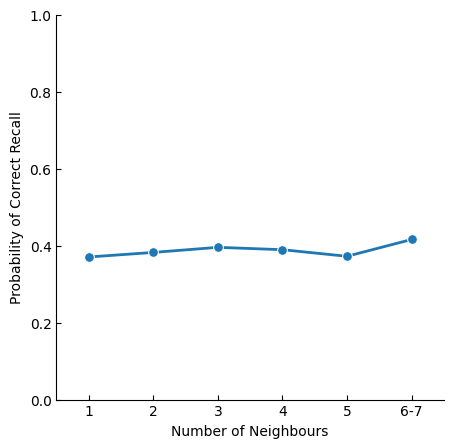

In [144]:
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_neighbour.query("neighbour_group > 0"), x='neighbour_group', y='correct', linewidth=2, marker='o', markersize = 7)
plt.ylim([0,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
# plt.savefig('fig/simu7_PLI.pdf')
plt.show()

In [145]:
df_ILI = df_simu.loc[df_simu.ITI == True]
df_ILI

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,study_pos,distance,neighbour,neighbour_group,correct,ITI
32,4,0,14,31.0,390.0,0.696473,Face14,22,0,"[2.9509, 2.9187, 2.4855, 1.8175, 2.3944, 3.368...",6,6,False,True
64,8,0,1,24.0,190.0,0.692592,Face1,30,7,"[1.0709, 2.202, 2.2233, 3.2373, 3.5772, 2.8095...",5,5,False,True
72,9,0,6,31.0,170.0,0.760662,Face6,27,3,"[2.202, 2.0108, 3.194, 2.8217, 3.9032, 1.6004,...",5,5,False,True
88,1,1,11,24.0,840.0,0.642658,Face11,18,2,"[3.7211, 2.7036, 3.3819, 3.0134, 3.2567, 2.573...",3,3,False,True
112,4,1,12,24.0,290.0,0.708063,Face12,32,7,"[3.5024, 1.9225, 3.6906, 2.9409, 3.2567, 3.678...",3,3,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7976,7,99,5,31.0,220.0,0.762401,Face5,19,4,"[2.0873, 1.601, 3.3872, 2.5197, 3.2177, 3.4192...",3,3,False,True
7977,7,99,15,19.0,250.0,0.712582,Face15,31,7,"[3.9391, 3.8765, 3.1458, 3.4192, 2.4733, 1.838...",3,3,False,True
7982,7,99,9,30.0,240.0,0.722772,Face9,17,3,"[3.5825, 3.2787, 3.3268, 3.2177, 3.3644, 1.838...",2,2,False,True
7992,9,99,3,31.0,170.0,0.755026,Face3,20,2,"[2.1647, 2.9597, 3.3872, 2.2956, 3.3268, 3.145...",3,3,False,True


In [146]:
df_ILI_neighbour = df_ILI.groupby("neighbour_group")['test_item'].count().to_frame(name='ILI_cnt').reset_index()
df_ILI_neighbour['neighbour_cnt'] = df_simu.groupby("neighbour_group")['test_item'].count()[1:].to_list()
df_ILI_neighbour['ILI_prob'] = df_ILI_neighbour['ILI_cnt'] / df_ILI_neighbour['neighbour_cnt']
df_ILI_neighbour

,neighbour_group,ILI_cnt,neighbour_cnt,ILI_prob
0,1,26,270,0.096296
1,2,63,900,0.070000
2,3,166,1980,0.083838
3,4,176,2340,0.075214
4,5,140,1870,0.074866
5,6,49,630,0.077778


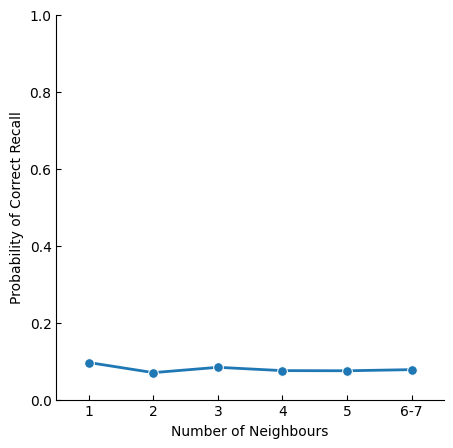

In [147]:
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_ILI_neighbour.query("neighbour_group > 0"), x='neighbour_group', y='ILI_prob', linewidth=2, marker='o', markersize = 7)
plt.ylim([0,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
# plt.savefig('fig/simu7_PLI.pdf')
plt.show()